In [1]:
# allows to bring all the functions, classes, and variables defined in the "utils" module into the current namespace.
from utils_Func import *

# Fig. 1

The purpose of this code snippet is to showcase the concept of intervals, rather than providing a full modeling workflow with train and test sets. It is a demonstration of the concept of prediction and confidence intervals. The focus is on visualizing the intervals and understanding their interpretation in the context of linear regression.

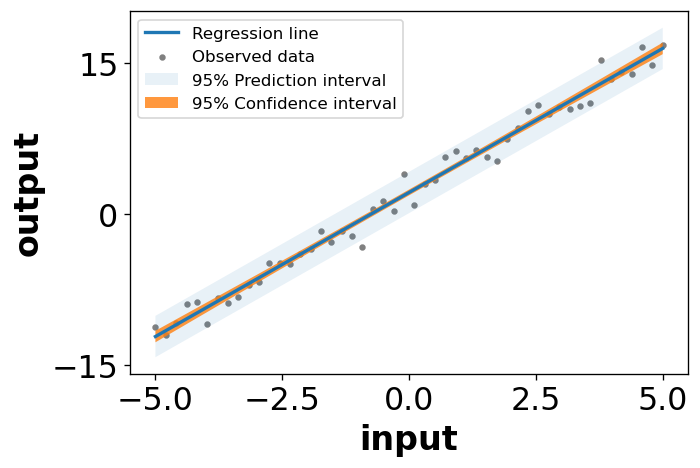

In [2]:
# Generate synthetic data
np.random.seed(0)
x = np.linspace(-5, 5, num=50)
y = 3 * x + 2 + np.random.normal(size=50)

# Fit linear regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)

# Make predictions
y_pred = model.predict(x.reshape(-1, 1))

# Calculate prediction intervals
prediction_interval = 1.96 * np.sqrt(mean_squared_error(y, y_pred))
lower_bound = y_pred - prediction_interval
upper_bound = y_pred + prediction_interval

# Calculate confidence intervals
confidence_interval = 1.96 * np.sqrt(np.mean((y - y_pred)**2) * (1 / len(x) + (x - x.mean())**2 / np.sum((x - x.mean())**2)))
lower_bound_ci = y_pred - confidence_interval
upper_bound_ci = y_pred + confidence_interval


plt.scatter(x, y,  color='gray', label='Observed data',s=8)
plt.fill_between(x, lower_bound,upper_bound, alpha=.1, label='95% Prediction interval')
plt.fill_between(x, lower_bound_ci,upper_bound_ci, alpha=.8, label='95% Confidence interval')
plt.plot(x, y_pred,  label='Regression line')
plt.yticks([-15,0,15])
plt.xlabel("input",fontweight ='bold',fontsize=20)
plt.ylabel("output",fontweight ='bold',fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Read Dataset

In [3]:
df50 = pd.read_csv('StrengthCorrelations_50um.csv')
df100 = pd.read_csv('StrengthCorrelations_100um.csv')
df50=df50.dropna(axis=0)
df100=df100.dropna(axis=0)
df50['UM']=50
df100['UM']=100
df = pd.concat([df50, df100])
# df=df100
df1 = df[['Vf_IQR', 'Vf_Mdn', 'nFC', 'nMRC', 'FCp', 'MRCp', 'av_FCa', 'av_MRCa', 'max_FC', 'max_MRC','Stiffness', 'Strength']]
X=df1.iloc[:,0:10].to_numpy()
y1=df1['Stiffness'].to_numpy()
y2=df1['Strength'].to_numpy()

# This notebook is for Stiffness. Just simply use y2 for Strength!

In summary, the code is dividing the data into training and test sets for both input features (X) and output target (y1). The input features are then standardized using the StandardScaler to ensure they have zero mean and unit variance. The same scaler is used to transform both the training and test features. Additionally, the output target (y1) is scaled similarly to have zero mean and unit variance.

The final step splits the training data into two parts: one for training the CQR model (X_train_cqr and y_train_cqr) and the other for calibrating the quantile levels for CQR (X_calib and y_calib). This calibration set is essential for ensuring that the CQR model provides well-calibrated prediction intervals.

In [4]:
# Split the data into training and test sets for input features (X) and output target (y1, Stiffness)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y1,  # Stiffness
    test_size=0.20,
    random_state=random_state
)

# Scaling Transformation for input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Scale the training features
X_test = scaler.transform(X_test)  # Scale the test features using the same transformation

# Scaling Transformation for output target (y1, Stiffness)
# Note: Inverse transform is used later to see the original values of predicted outputs!
y_train = scaler.fit_transform(y_train.reshape(-1, 1))  # Scale the training target
y_test = scaler.transform(y_test.reshape(-1, 1))  # Scale the test target using the same transformation

# Split the training data further into CQR training and calibration sets
# The calibration set is used to calibrate the quantile levels for CQR
X_train_cqr, X_calib, y_train_cqr, y_calib = train_test_split(
    X_train,
    y_train,
    random_state=random_state
)


# Define base regressor of CV+ and CQR!

The code provided is performing hyperparameter optimization for the LightGBM (LGBM) regressor using Randomized Search with cross-validation.

In summary, the code initializes a LightGBM regressor for quantile regression with a predefined quantile level (alpha). It then defines the hyperparameter space to be explored during the hyperparameter optimization using Randomized Search. The hyperparameter space includes num_leaves, max_depth, n_estimators, and learning_rate. Randomized Search is then used to find the best combination of hyperparameters using cross-validation. The final estimator is updated with the best hyperparameters found during optimization, making it ready for use in quantile regression tasks.

In [5]:
# Create the LGBMRegressor as an estimator for quantile regression
estimator = LGBMRegressor(
    objective='quantile',  # Objective set to 'quantile' for quantile regression
    alpha=0.5,  # The quantile level (0.5 for median, 0.9 for 90th percentile, etc.)
    random_state=random_state  # Set the random seed for reproducibility
)

# Define the hyperparameter space for RandomizedSearchCV
params_distributions = dict(
    num_leaves=randint(low=10, high=50),  # Number of leaves in each decision tree
    max_depth=randint(low=3, high=20),  # Maximum depth of each decision tree
    n_estimators=randint(low=50, high=300),  # Number of boosting stages (trees)
    learning_rate=uniform()  # Learning rate for gradient boosting
)

# Hyperparameter Optimization using RandomizedSearchCV
# RandomizedSearchCV explores randomly selected hyperparameter combinations within the given distribution
optim_model = RandomizedSearchCV(
    estimator,  # The LGBMRegressor model as the estimator
    param_distributions=params_distributions,  # Hyperparameter space to search
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    n_iter=100,  # Number of random combinations to try
    cv=KFold(n_splits=5, shuffle=True),  # 5-fold cross-validation for model evaluation
    verbose=-1  # Set the verbosity level to show progress during optimization
)

# Fit the RandomizedSearchCV to find the best hyperparameter configuration
optim_model.fit(X_train, y_train)

# Update the estimator to use the best hyperparameters found during optimization
estimator = optim_model.best_estimator_


 the code sets up an evaluation process for the CV_plus method using different target coverage levels (quantiles) and stores the evaluation results in a dictionary called results. The results dictionary will have entries for each method and corresponding evaluation results for each target coverage level.

In [6]:
# We can evaluate the performance of the CV_plus method for multiple target coverage levels
# and save the results in a dictionary where each entry corresponds to a different target coverage level.
# The `levels` list contains the target quantiles for which coverage is calculated (e.g., [0.1, 0.05, 0.01] 
# corresponds to coverage levels of 90%, 95%, and 99%).
# The `funcs` list contains the corresponding methods/functions to evaluate (e.g., CV_plus for cross-validation with '+').
# The `names` list contains the names of the methods (e.g., ['CV+']).
# The `results` dictionary will store the evaluation results for each method and target coverage level.

levels = [0.1, 0.05, 0.01]  # List of target quantiles: [0.1, 0.05, 0.01] corresponding to 90%, 95%, and 99% coverage levels
funcs = [CV_plus]  # List of methods/functions to evaluate, e.g., CV_plus for cross-validation with '+'
names = ['CV+']  # List of method names, e.g., ['CV+']

results = {}  # Dictionary to store the evaluation results for each method and target coverage level

# Loop through each method and evaluate its performance for each target coverage level
for name, func in zip(names, funcs):
    res = []
    for level in levels:
        # Call the specified function to evaluate the method's performance
        result = func(X_train, y_train, X_test, y_test, estimator, alpha=level)
        res.append(result)
    # Store the results for the current method in the results dictionary
    results[name] = res

# results

# Save results of CQR for three different confidence levels

 these lines of code are performing three separate calls to the CQR method to calculate prediction intervals for three different target coverage levels (quantiles) and saving the results in three variables: CQR_result_90, CQR_result_95, and CQR_result_99. Each result will contain information about the coverage, width, and the prediction intervals for the corresponding target coverage level.

In [7]:
# Calculate prediction intervals using the CQR method for three different target coverage levels (quantiles)
# and store the results in separate variables.

# Calculate prediction intervals for a target coverage level of 90% (quantile 0.1)
CQR_result_90 = CQR(X_train_cqr, y_train_cqr.reshape(-1), X_calib, y_calib.reshape(-1), X_test, y_test.reshape(-1), estimator, alpha=0.1)

# Calculate prediction intervals for a target coverage level of 95% (quantile 0.05)
CQR_result_95 = CQR(X_train_cqr, y_train_cqr.reshape(-1), X_calib, y_calib.reshape(-1), X_test, y_test.reshape(-1), estimator, alpha=0.05)

# Calculate prediction intervals for a target coverage level of 99% (quantile 0.01)
CQR_result_99 = CQR(X_train_cqr, y_train_cqr.reshape(-1), X_calib, y_calib.reshape(-1), X_test, y_test.reshape(-1), estimator, alpha=0.01)


In [8]:
# Create a DataFrame 'a' to store the true values (y_test) and the prediction intervals
# generated by the CQR method with a target coverage level of 95% (cqr_5low and cqr_5up),
# as well as the prediction intervals generated by the CV+ method (CV_5low and CV_5up).

# Construct the DataFrame 'a' using the zip function to combine the columns of interest.
a = pd.DataFrame(
    list(zip(
        y_test.reshape(-1),  # True values (y_test) in a flattened format
        CQR_result_95[1]['cqr'][:, 0, 0],  # Lower bounds of CQR prediction intervals
        CQR_result_95[1]['cqr'][:, 1, 0],  # Upper bounds of CQR prediction intervals
        results['CV+'][1][0][3][:, 0],    # Lower bounds of CV+ prediction intervals
        results['CV+'][1][0][3][:, 1],    # Upper bounds of CV+ prediction intervals
    )),
    columns=[
        'y_test',     # True values (y_test) column
        'cqr_5low',   # Lower bounds of CQR prediction intervals column
        'cqr_5up',    # Upper bounds of CQR prediction intervals column
        'CV_5low',    # Lower bounds of CV+ prediction intervals column
        'CV_5up',     # Upper bounds of CV+ prediction intervals column
    ]
)

# Sort the DataFrame 'a' based on the 'y_test' values in ascending order.
a_sort = a.sort_values(by=['y_test'])

a_sort

,y_test,cqr_5low,cqr_5up,CV_5low,CV_5up
194,-1.962823,-2.168605,-1.495808,-2.176668,-1.325918
282,-1.887660,-2.168162,-1.131627,-2.166726,-1.302839
275,-1.855487,-2.243762,-0.782827,-1.996362,-1.168569
77,-1.821197,-2.268744,-1.108762,-2.180820,-1.346291
157,-1.744945,-2.266388,-1.110774,-2.220696,-1.383964
...,...,...,...,...,...
222,2.075204,1.164506,2.338923,1.436468,2.303718
162,2.093540,1.536336,2.477631,1.658467,2.510641
13,2.214721,0.941853,2.820701,1.649507,2.535012
106,2.390057,1.523863,3.053214,2.005040,2.875393


# Check the number of incorrect prediction intervals

The code you provided calculates the number of data points where the prediction intervals generated by the CQR method (cqr_5low and cqr_5up) and the CV+ method (CV_5low and CV_5up) miss the true values (y_test). It identifies the points where the true value falls outside the respective prediction intervals and then counts the occurrences for each method.

In [9]:
# Identify the data points where the CQR method's prediction intervals miss the true values.
# A prediction interval is considered "missed" if the true value falls outside the interval.
# Create a DataFrame 'misCQR' containing such data points.
misCQR = a_sort[(a_sort.cqr_5low > a_sort['y_test']) | (a_sort.cqr_5up < a_sort['y_test'])]

# Identify the data points where the CV+ method's prediction intervals miss the true values.
# A prediction interval is considered "missed" if the true value falls outside the interval.
# Create a DataFrame 'misCV' containing such data points.
misCV = a_sort[(a_sort.CV_5low > a_sort['y_test']) | (a_sort.CV_5up < a_sort['y_test'])]

# Create a dictionary 'missed' to store the number of missed data points for each method.
# The count of missed data points for the CV+ method is stored in the 'CV+' key,
# and the count of missed data points for the CQR method is stored in the 'CQR' key.
missed = {}
missed['CV+'] = len(misCV.index)  # Count the number of missed data points for CV+
missed['CQR'] = len(misCQR.index)  # Count the number of missed data points for CQR

missed

{'CV+': 5, 'CQR': 14}

The code you provided calculates the coverage and width of the prediction intervals generated by the CQR and CV+ methods, respectively, and stores the results in the dictionaries coverage and width.

In [10]:
# Extract the true target values ('y_test') and the prediction intervals for CQR and CV+ methods from the sorted DataFrame.
# Store the prediction intervals for each method in the dictionary 'r', where 'CQR' and 'CV+' are the keys.
# The values associated with the 'CQR' key are the lower ('cqr_5low') and upper ('cqr_5up') bounds of the CQR prediction intervals.
# The values associated with the 'CV+' key are the lower ('CV_5low') and upper ('CV_5up') bounds of the CV+ prediction intervals.
y_test = a_sort.y_test.values
r = {}
r['CQR'] = np.array(a_sort[['cqr_5low', 'cqr_5up']])
r['CV+'] = np.array(a_sort[['CV_5low', 'CV_5up']])

# Create dictionaries 'coverage' and 'width' to store the coverage and width values for each method.
# 'coverage' will store the coverage scores, and 'width' will store the average width of the prediction intervals.
coverage = {}
width = {}

# Define the methods for which we want to calculate coverage and width (CV+ and CQR).
names = ['CV+', 'CQR']

# Calculate the coverage and width for each method.
for name in names:
    # Calculate the coverage score for the current method, rounding the value to three decimal places.
    coverage[name] = round(coverage_score(y_test, r[name][:, 0], r[name][:, 1]), 3)
    
    # Calculate the average width of the prediction intervals for the current method, rounding the value to three decimal places.
    width[name] = (r[name][:, 1] - r[name][:, 0]).mean().round(3)


# True Value Vs. Prediction Interval

This code creates a side-by-side comparison of the prediction intervals generated by the CV+ and CQR methods for the test points. The visualization allows you to compare the performance of both methods in generating prediction intervals for the true stiffness values. The legend provides a visual guide for differentiating the CV+ and CQR methods' prediction intervals. The x-axis represents the true stiffness values, and the y-axis represents the prediction intervals.

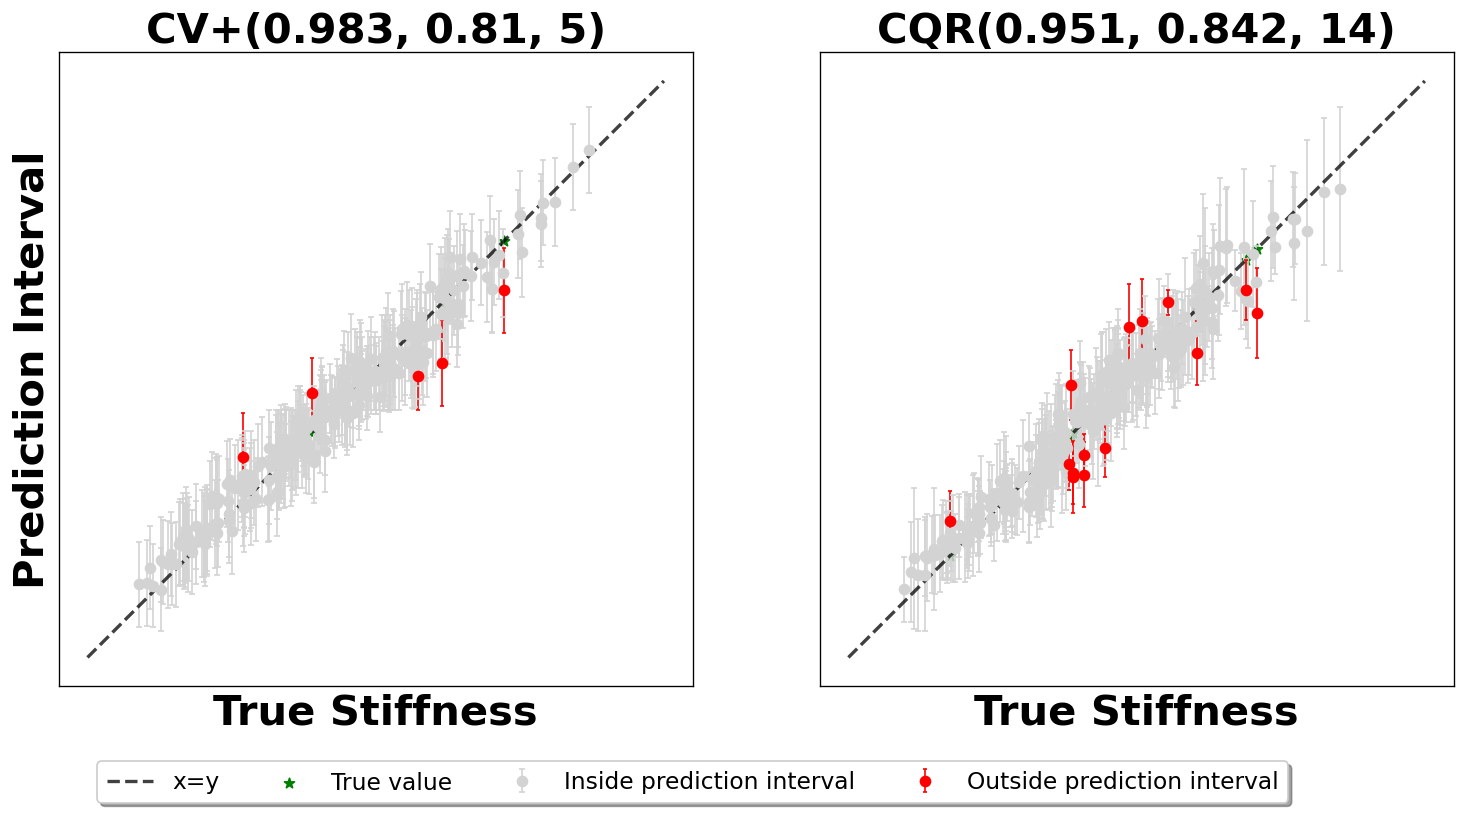

In [11]:
# We can visualize all test points or a random fraction of it!
# Set perc_obs_plot to 1 if you want to show all test points.
perc_obs_plot = 1

# Calculate the number of test points to be plotted based on the percentage specified in perc_obs_plot.
num_plots = rng.choice(len(y_test), int(perc_obs_plot * len(y_test)), replace=False)

# Create a 1x2 subplot figure to plot the prediction intervals for CV+ and CQR methods.
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot the prediction intervals for CV+ method.
plot_PI(
    "CV+",
    axs[0],
    y_test,
    r["CV+"].mean(axis=1).ravel(),
    r["CV+"][:, 0],
    r["CV+"][:, 1],
    coverage["CV+"],
    results["CV+"][1][0][2],
    missed["CV+"],
    num_plots
)

# Plot the prediction intervals for CQR method.
plot_PI(
    "CQR",
    axs[1],
    y_test,
    r['CQR'].mean(axis=1).ravel(),
    r['CQR'][:, 0],
    r['CQR'][:, 1],
    round(coverage['CQR'], 3),
    width['CQR'],
    missed["CQR"],
    num_plots
)

# Set labels for the y-axis and x-axis in the subplots.
axs[0].set_ylabel("Prediction Interval", fontweight='bold', fontsize=25)
axs[0].set_xlabel("True Stiffness", fontweight='bold', fontsize=25)
axs[1].set_xlabel("True Stiffness", fontweight='bold', fontsize=25)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

# Extract the legend handles and labels from the axes and combine them.
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]

# Create the legend for the subplots, containing the labels for the CV+ and CQR methods.
plt.legend(
    lines[:4], labels[:4],
    loc='upper center',
    bbox_to_anchor=(-0.2, -0.1),  # Adjust the legend position as per requirement.
    fancybox=True,
    shadow=True,
    ncol=4, fontsize=14,
)

# Display the plot.
plt.show()


# Check conditional coverage of 10 different bins!

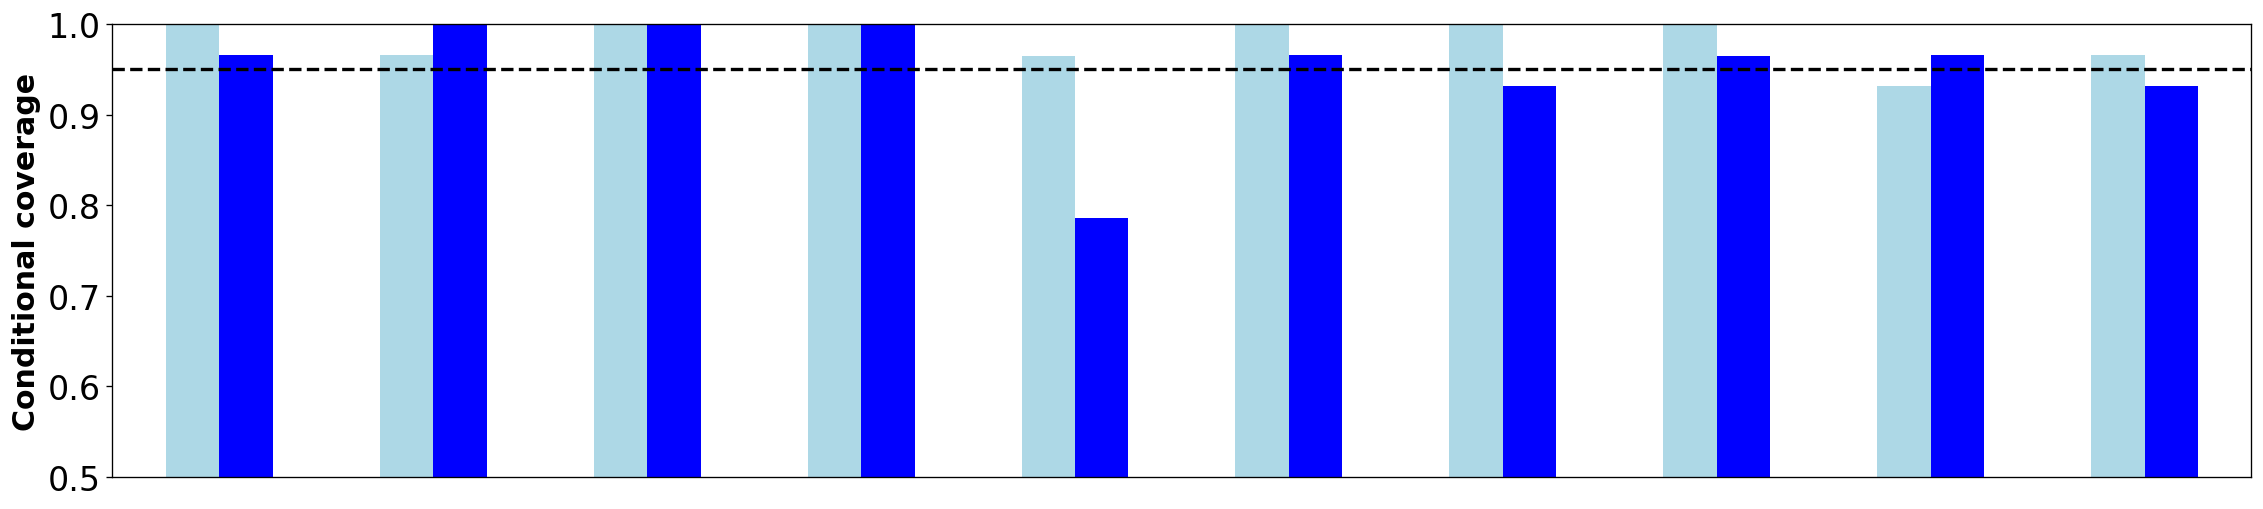

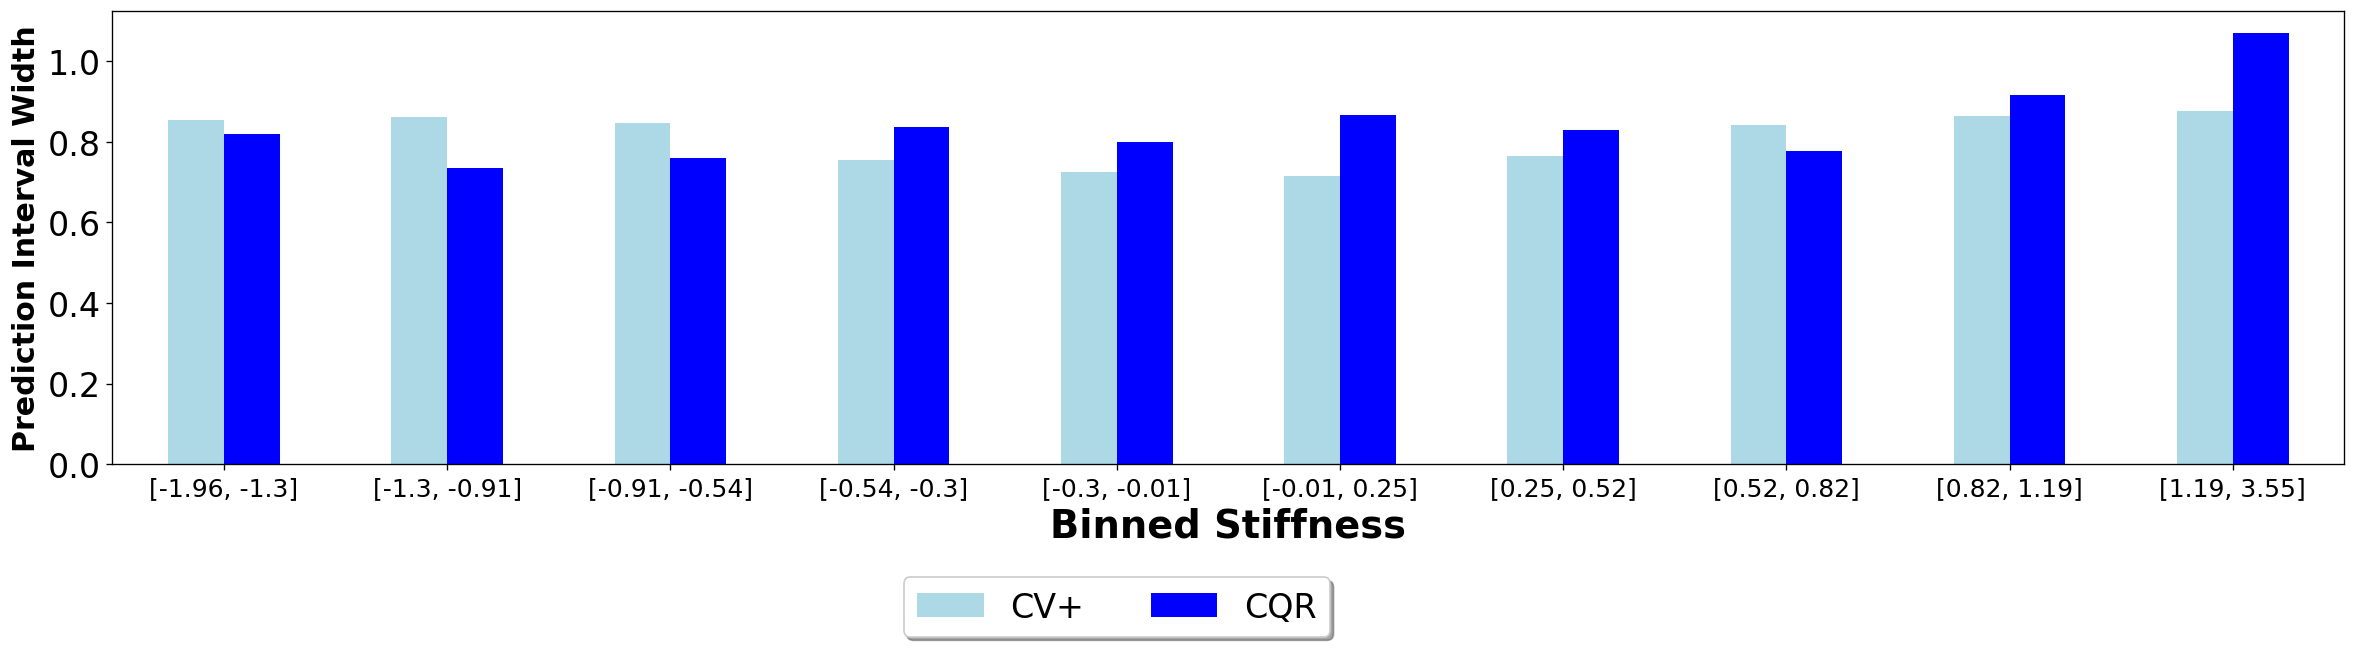

In [12]:
y_testt=a_sort.y_test.values

names=['CV+','CQR']
bins = list(np.arange(0, 1, 0.1))
mpl.rc('ytick', labelsize=20)
binned = widths_bins(
    "coverage",
    y_testt, r, a_sort, names, bins
)
binned.T.plot.bar(figsize=(23, 5), color=['lightblue','blue','darkblue'])
plt.axhline(0.95, ls="--", color="k")
plt.ylabel("Conditional coverage",fontweight ='bold',fontsize=18)
plt.xticks(rotation=345)
plt.xticks([])
plt.ylim(0.5, 1.0)
legend = plt.legend(handles=[], labels= [])
legend.remove()
plt.show()
mpl.rc('ytick', labelsize=20)
mpl.rc('xtick', labelsize=15)
binned = widths_bins(
    "width",
    y_testt, r, a_sort, names, bins
)
binned.T.plot.bar(figsize=(24, 5), color=['lightblue','blue','darkblue'])
plt.ylabel("Prediction Interval Width",fontweight ='bold',fontsize=18)
plt.xlabel("Binned Stiffness",fontweight ='bold',fontsize=23)
plt.xticks(rotation=0)
plt.legend( loc='upper center', bbox_to_anchor=(0.45, -0.25),
              fancybox=True, shadow=True, ncol=5,fontsize=20, borderaxespad=0.)
plt.show()